In [1]:
%matplotlib inline
import argparse
import glob
import os
import sys
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

from networks.drn_seg import DRNSeg
from utils.tools import *
from utils.visualize import *
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

In [9]:
# load default model
default_model_path = './weights/local.pth'
gpu_id = 0
no_crop = True

# Loading the model
if torch.cuda.is_available():
    print(f'cuda:{gpu_id} is available')
    device = 'cuda:{}'.format(gpu_id)
else:
    print(f'cuda is not available')
    device = 'cpu'

default_model = DRNSeg(2)
state_dict = torch.load(default_model_path, map_location=device)
default_model.load_state_dict(state_dict['model'])
default_model.to(device)
default_model.eval()

cuda is not available


DRNSeg(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(3

In [21]:
# load model
model_path = './japanese_model3.pth'
gpu_id = 0
no_crop = True

# Loading the model
if torch.cuda.is_available():
    print(f'cuda:{gpu_id} is available')
    device = 'cuda:{}'.format(gpu_id)
else:
    print(f'cuda is not available')
    device = 'cpu'

model = DRNSeg(2)
state_dict = torch.load(model_path, map_location=device)
# model.load_state_dict(state_dict['model'])
model.load_state_dict(state_dict)
model.to(device)
model.eval()

cuda is not available


DRNSeg(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(3

In [22]:
def predict(model, modified_img_path, original_img_path):
    dest_folder = './out/anzu'
    if True:
    # Data preprocessing
        tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        im_w, im_h = Image.open(modified_img_path).size
        if no_crop:
            face = Image.open(modified_img_path).convert('RGB')
            original_face = Image.open(original_img_path).convert('RGB')
        else:
            faces = face_detection(modified_img_path, verbose=False)
            if len(faces) == 0:
                print("no face detected by dlib, exiting")
                sys.exit()
            face, box = faces[0]
        face = resize_shorter_side(face, 400)[0]
        original_face = resize_shorter_side(original_face, 400)[0]
        face_tens = tf(face).to(device)




        # Warping field prediction
        with torch.no_grad():
            flow = model(face_tens.unsqueeze(0))
            _flow = flow
            flow = flow[0].cpu().numpy()


         # calc y_flow
        _, _h, _w = flow.shape
        resized_face = face.resize((_w, _h), Image.BICUBIC)
        resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
        resized_face_np = np.asarray(resized_face)
        resized_original_face_np = np.asarray(resized_original_face)
        resized_face_gray = cv2.cvtColor(resized_face_np,cv2.COLOR_BGR2GRAY)
        resized_original_face_gray = cv2.cvtColor(resized_original_face_np,cv2.COLOR_BGR2GRAY)
        y_flow = cv2.calcOpticalFlowFarneback(resized_face_gray,resized_original_face_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        y_flow_tensor = torch.from_numpy(y_flow)
        y_flow_reshaped = y_flow_tensor.reshape(flow.shape)
        flow = np.transpose(flow, (1, 2, 0))
        h, w, _ = flow.shape

        # Undoing the warps
        print(f"w is {w} and h is {h}")
        modified = face.resize((w, h), Image.BICUBIC)
        modified_np = np.asarray(modified)
        reverse_np = warp(modified_np, flow)
        reverse = Image.fromarray(reverse_np)
        flow_magn = np.sqrt(flow[:, :, 0] **2 + flow[:, :, 1]**2)
        heatmapped = Image.fromarray(get_heatmap_cv(modified_np, flow_magn, 7))
    #     modified_gray = cv2.cvtColor(modified_np,cv2.COLOR_BGR2GRAY)
    #     reverse_gray = cv2.cvtColor(reverse_np,cv2.COLOR_BGR2GRAY)
    #     cv_flow = cv2.calcOpticalFlowFarneback(modified_gray,reverse_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        y_reverse_np = warp(modified_np, - y_flow)
        y_reverse = Image.fromarray(y_reverse_np)
        y_flow_magn = np.sqrt(y_flow[:, :, 0]**2 + y_flow[:, :, 1]**2)
        y_heatmapped = Image.fromarray(get_heatmap_cv(modified_np, y_flow_magn, 7))
        return resized_original_face, modified, heatmapped, y_heatmapped, reverse, y_reverse

In [23]:
def show(resized_original_face, modified, heatmapped, y_heatmapped, reverse, y_reverse):
    fig = plt.figure()
    ax1 = fig.add_subplot(2,3,1)
    ax2 = fig.add_subplot(2,3,2)
    ax3 = fig.add_subplot(2,3,3)
    ax4 = fig.add_subplot(2,3,4)
    ax5 = fig.add_subplot(2,3,5)
    ax6 = fig.add_subplot(2,3,6)
    ax1.imshow(np.array(resized_original_face))
    ax2.imshow(np.array(modified))
    ax3.imshow(np.array(heatmapped))
    ax4.imshow(np.array(y_heatmapped))
    ax5.imshow(np.array(reverse))
    ax6.imshow(np.array(y_reverse))

In [24]:
modified_img_path = './examples/natsuki_kataoka_modified.png'
original_img_path = './examples/natsuki_kataoka_original.png'
resized_original_face, modified, \
    heatmapped, y_heatmapped, \
    reverse, y_reverse = predict(model, modified_img_path, original_img_path)
d_resized_original_face, d_modified, \
    d_heatmapped, d_y_heatmapped, \
    d_reverse, d_y_reverse = predict(default_model, modified_img_path, original_img_path)

/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_45766/3695161420.py:37: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_face = face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_45766/3695161420.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_45766/3695161420.py:51: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  modified = face.resize((w, h), Image.BICUBIC)


w is 400 and h is 512
w is 400 and h is 512


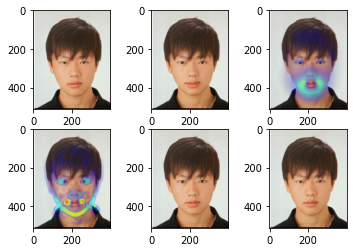

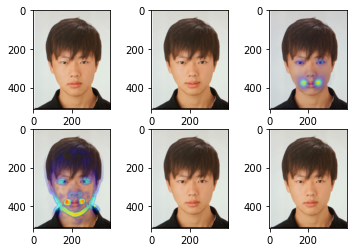

In [25]:
show(d_resized_original_face, d_modified, d_heatmapped, d_y_heatmapped, d_reverse, d_y_reverse)
show(resized_original_face, modified, heatmapped, y_heatmapped, reverse, y_reverse)

In [27]:
modified_img_path = './examples/natsuki_kataoka_original.png'
original_img_path = './examples/natsuki_kataoka_original.png'
resized_original_face, modified, \
    heatmapped, y_heatmapped, \
    reverse, y_reverse = predict(model, modified_img_path, original_img_path)
d_resized_original_face, d_modified, \
    d_heatmapped, d_y_heatmapped, \
    d_reverse, d_y_reverse = predict(default_model, modified_img_path, original_img_path)

/Users/yuki/情報科学演習3/yokoyaken/venv/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_45766/3695161420.py:37: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_face = face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_45766/3695161420.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_45766/3695161420.py:51: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  modified = face.resize((w, h), Image.BICUBIC)


w is 400 and h is 512
w is 400 and h is 512


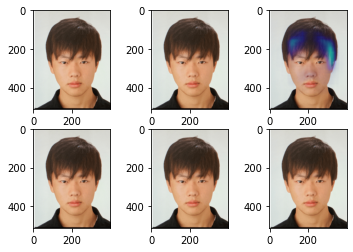

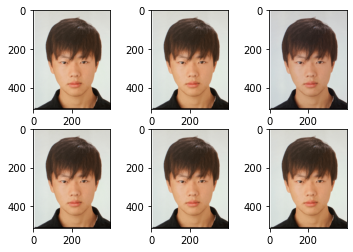

In [28]:
show(d_resized_original_face, d_modified, d_heatmapped, d_y_heatmapped, d_reverse, d_y_reverse)
show(resized_original_face, modified, heatmapped, y_heatmapped, reverse, y_reverse)

In [26]:
# show(d_resized_original_face, d_modified, d_heatmapped, d_y_heatmapped, d_reverse, d_y_reverse)

In [31]:
import string, random

In [32]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [59]:
''.join(random.choices(string.ascii_letters+string.digits, k=6))

'qte3UW'

In [44]:
len(string.ascii_letters+string.digits)

62

In [45]:
62**6

56800235584